# Aging aware training

$$ \min_\theta \,\int_{t=0}^{1} \; L(\theta(t)) \, dt $$
where  $\theta(t)$ is a fitted model of the conductance over time

## Monte Carlo approximation:

### Introduction

The goal is to integrate the following formular
$$
\int_t f(t){\rm d}t
$$
Rectangular approximation is 
$$
\sum_n f[n\Delta k]\Delta k
$$
The problem is that, if the sampling rate is lower than twice the frequencce of the function, the error would be large, e.g., integrating a $f(t)=\sin(2\pi (t+\frac{1}{4}))$ with sampling rate $\Delta k=1$, i.e.,
$$
\int_tf(t){\rm d}t\approx\sum_n \sin \left(2\pi (n+\frac{1}{4})\right)=n,
$$
which is obviously wrong.

### Monte Carlo Approximation

Recall the definition of **Expectation** of a distribution
$$
\begin{align}
\mathbb{E}\{x\}&=\int_x x\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N x_n,\ x_n\sim p(x)
\end{align}
$$
Further, 
$$
\begin{align}
\mathbb{E}\{f(x)\}&=\int_x f(x)\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N f(x_n),\ x_n\sim p(x)
\end{align}
$$
For a given integration task $\int_x f(x) {\rm d}x$, we can approximate this by
$$
\int_x f(x) {\rm d}x=\int_x f(x)\cdot 1 {\rm d}x=\int_x f(x)\cdot \frac{p(x)}{p(x)} {\rm d}x=\int_x\frac{f(x)}{p(x)}\cdot p(x) {\rm d}x=\mathbb{E}\left\{\frac{f(x)}{p(x)}\right\}\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)},\ x_n\sim p(x)
$$
Let $p(x)$ is a uniform distribution, e.g., $p(x)=\frac{1}{b-a},\ x\in[a,b]$, we have
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)}=\frac{b-a}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x).
$$
Let $b=1$ and $a=0$, 
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x),
$$
i.e., we can approximate the integration by averaging the randomly sampled value $f(x)$, with $x$ following uniform distribution.

Moreover, the method in the introduction is a special case of Monte Carlo method.
## Aging Aware Training

The goal of aging aware training is
$$
\min_{\theta_{\rm init}} \int_{t=0}^1 L(\theta(t)){\rm d}t,
$$
where $\theta(t)=\theta_{\rm init}\cdot\mathop{A}(t)$ denotes the aging of the resistors. Using Monto Carlo method, it is converted to
$$
\min_{\theta_{\rm init}} \frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right),
$$
where $\mathfrak{K}$ is a set of $K$ uniform randomly sampled timestamps $k\in[0,1]$.

To minimize this function, i.e., $\frac{1}{N}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)$, we apply intuitively the gradient descent:
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot \sum_{k\in \mathfrak{K} } \nabla_{\theta_{\rm init}}\left(L \left(\theta[k]\right)\right)\\
\end{align}
$$

# Get aging model

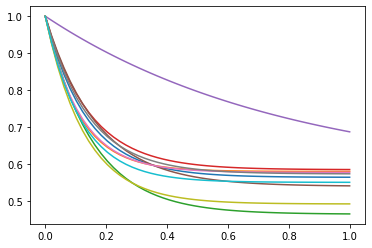

In [1]:
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import fake_data as data
import random
import numpy as np
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))
import torch
from torch.autograd import Variable
import torch.nn.functional as F

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)
vals = np.linspace(0,1)
age_models = age_generator.get_models(10)
for k in age_models:
    plt.plot(vals, k(vals));

## Prepare data

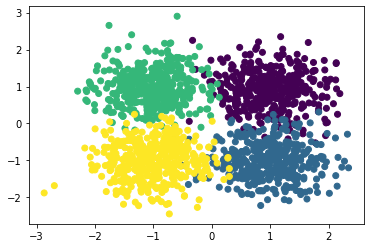

(torch.Size([1120, 2]), torch.Size([1120]))

In [2]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);


X, Y = data.GenerateData(N=400, var=0.5, plot=True)
X_train, Y_train, X_test, Y_test = data.SplitData(X, Y, 0.7)
X_train, Y_train, X_test, Y_test = X_train.T, Y_train.T.flatten(), X_test.T, Y_test.T.flatten()

x_train, y_train = torch.from_numpy(X_train).type(torch.FloatTensor), torch.from_numpy(Y_train).type(torch.LongTensor)
x_test, y_test = torch.from_numpy(X_test).type(torch.FloatTensor), torch.from_numpy(Y_test).type(torch.LongTensor)
x_train, y_train = Variable(x_train), Variable(y_train)
x_test, y_test = Variable(x_test), Variable(y_test)
x_train.shape, y_train.shape

## Try to get aged theta

In [3]:
import importlib
importlib.reload(pnn)

# generate NN, the initial time, i.e., pnn.PNNLayer.t = 0.
mypnn = torch.nn.Sequential(pnn.PNNLayer(2,5, age_generator),
                            pnn.PNNLayer(5,5, age_generator),
                            pnn.PNNLayer(5,4, age_generator))
counter = 1
for i in mypnn:
    print(f"The {counter}-th layer:")
    counter += 1
    
    print(f"theta at t={i.t}\n", i.theta_aged)    # print theta
    i.t = 0.1         # change time
    print(f"theta at t={i.t}\n", i.theta_aged)    # print aged theta
    
    print("\n")

The 1-th layer:
theta at t=0
 tensor([[4.9626e-01, 7.6822e-01, 2.9828e+00, 1.3203e+01],
        [3.0742e-01, 6.3408e-01, 1.9585e+01, 8.9644e+01],
        [4.5563e-01, 6.3231e-01, 8.8458e+00, 4.0172e+01],
        [2.2326e-02, 1.6886e-01, 1.1295e+01, 5.1852e+01],
        [6.9767e-01, 8.0001e-01, 6.2977e+00, 2.8227e+01]],
       grad_fn=<ViewBackward0>)
theta at t=0.1
 tensor([[3.6605e-01, 6.2795e-01, 2.1302e+00, 9.6863e+00],
        [2.5182e-01, 5.0316e-01, 1.4867e+01, 7.6330e+01],
        [3.2011e-01, 5.6530e-01, 6.5766e+00, 2.9165e+01],
        [1.6570e-02, 1.2739e-01, 8.7346e+00, 4.2023e+01],
        [4.9437e-01, 6.1596e-01, 4.7048e+00, 2.2319e+01]],
       grad_fn=<ViewBackward0>)


The 2-th layer:
theta at t=0
 tensor([[6.8161e-01, 9.1519e-01, 3.9710e-01, 8.7416e-01, 4.1941e-01, 2.1368e+01,
         9.5274e+01],
        [3.6165e-02, 1.8523e-01, 3.7342e-01, 3.0510e-01, 9.3200e-01, 6.0710e+00,
         2.6983e+01],
        [1.5068e-01, 3.1720e-02, 2.0813e-01, 9.2980e-01, 7.2311e-01, 1

# Definations

In [4]:
MyAgedPNN = torch.nn.Sequential(pnn.PNNLayer(2,3, age_generator),
                                pnn.PNNLayer(3,3, age_generator),
                                pnn.PNNLayer(3,4, age_generator))
alpha = 0.005
m = 0.3
T = 0.1
K = 35
optimizer_aged = torch.optim.Adam(MyAgedPNN.parameters(), lr=0.1/K)
MyAgedPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
)

In [5]:
MyPNN = torch.nn.Sequential(pnn.PNNLayer(2,3, age_generator),
                            pnn.PNNLayer(3,3, age_generator),
                            pnn.PNNLayer(3,4, age_generator))
optimizer = torch.optim.Adam(MyPNN.parameters(), lr=alpha)
MyPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
)

In [6]:
myparameter = []
myloss = []
for s in range(2000):
    optimizer.zero_grad()
    
    prediction = MyPNN(x_train)
    loss = pnn.LossFunction(prediction, y_train, m, T)
    loss.backward()
    
    optimizer.step()

    if s % 10 == 0:
        temp = []
        prediction_test = MyPNN(x_test)
        p = torch.max(F.softmax(prediction_test, dim=0), 1)[1]
        pred_y = p.data.numpy().squeeze()
        acc_test = sum(pred_y == Y_test) / Y_test.shape[0]
        loss_test = pnn.LossFunction(prediction_test, y_test, m, T)

        temp = [l.theta_.data.clone() for l in MyPNN]
        myparameter.append(temp)
        myloss.append(loss_test.data)
        print(f'| Epoch: {s:-6d} | Accuracy: {acc_test:.5f} | Loss: {loss_test.data:.5f} |')
print('Finished.')

| Epoch:      0 | Accuracy: 0.15208 | Loss: 0.76594 |
| Epoch:     10 | Accuracy: 0.15833 | Loss: 0.72512 |
| Epoch:     20 | Accuracy: 0.49583 | Loss: 0.69955 |
| Epoch:     30 | Accuracy: 0.58125 | Loss: 0.69230 |
| Epoch:     40 | Accuracy: 0.62500 | Loss: 0.68517 |
| Epoch:     50 | Accuracy: 0.65417 | Loss: 0.67607 |
| Epoch:     60 | Accuracy: 0.68125 | Loss: 0.66444 |
| Epoch:     70 | Accuracy: 0.71667 | Loss: 0.65160 |
| Epoch:     80 | Accuracy: 0.73125 | Loss: 0.63973 |
| Epoch:     90 | Accuracy: 0.74792 | Loss: 0.62811 |
| Epoch:    100 | Accuracy: 0.77292 | Loss: 0.61550 |
| Epoch:    110 | Accuracy: 0.74792 | Loss: 0.60025 |
| Epoch:    120 | Accuracy: 0.77083 | Loss: 0.58309 |
| Epoch:    130 | Accuracy: 0.80625 | Loss: 0.56452 |
| Epoch:    140 | Accuracy: 0.82500 | Loss: 0.54230 |
| Epoch:    150 | Accuracy: 0.85000 | Loss: 0.51616 |
| Epoch:    160 | Accuracy: 0.86250 | Loss: 0.48597 |
| Epoch:    170 | Accuracy: 0.87292 | Loss: 0.44354 |
| Epoch:    180 | Accuracy: 

tensor(0.0657, dtype=torch.float64)

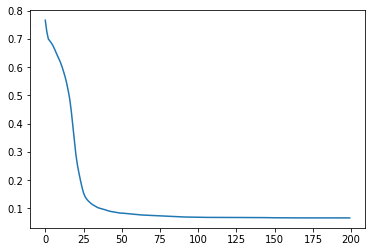

In [7]:
plt.plot(myloss);
best = np.argmin(myloss)
bestparameter = myparameter[best]
for l in range(len(bestparameter)):
    MyPNN[l].theta_.data = bestparameter[l]
prediction_test = MyPNN(x_test)
loss_test = pnn.LossFunction(prediction_test, y_test, m, T)
loss_test.data

In [8]:
myparameter = []
myloss = []
for s in range(2000):
    optimizer_aged.zero_grad()
    
    TimeSet = np.random.rand(K)
    for k in TimeSet:
        for i in MyAgedPNN:
            i.t = k
        prediction = MyAgedPNN(x_train)
        loss = pnn.LossFunction(prediction, y_train, m, T)
        loss.backward()
    
    optimizer_aged.step()

    if s % 10 == 0:
        temp = []
        avg_loss = 0
        avg_acc = 0
        
        test_time = np.linspace(0,1,100)
        for test_t in test_time:
            for i in MyAgedPNN:
                i.t = test_t    
            prediction = MyAgedPNN(x_test)
            loss = pnn.LossFunction(prediction, y_test, m, T)
            p = torch.max(F.softmax(prediction, dim=0), 1)[1]
            pred_y = p.data.numpy().squeeze()
            acc = sum(pred_y == Y_test) / Y_test.shape[0]
            
            avg_loss += loss.data
            avg_acc += acc
        
        avg_loss /= 100
        avg_acc /= 100
        
        myloss.append(avg_loss)
        temp = [l.theta_.data.clone() for l in MyAgedPNN]
        myparameter.append(temp)
        
        print(f'| Epoch: {s:-6d} | Accuracy: {avg_acc:.5f} | Loss: {avg_loss:.5f} |')

print('Finished.')

| Epoch:      0 | Accuracy: 0.25123 | Loss: 1.40407 |
| Epoch:     10 | Accuracy: 0.24027 | Loss: 1.35253 |
| Epoch:     20 | Accuracy: 0.22173 | Loss: 1.30175 |
| Epoch:     30 | Accuracy: 0.18329 | Loss: 1.26339 |
| Epoch:     40 | Accuracy: 0.17642 | Loss: 1.21267 |
| Epoch:     50 | Accuracy: 0.19971 | Loss: 1.15625 |
| Epoch:     60 | Accuracy: 0.20329 | Loss: 1.12200 |
| Epoch:     70 | Accuracy: 0.21300 | Loss: 1.09159 |
| Epoch:     80 | Accuracy: 0.26194 | Loss: 1.05647 |
| Epoch:     90 | Accuracy: 0.47750 | Loss: 1.02403 |
| Epoch:    100 | Accuracy: 0.49092 | Loss: 0.99513 |
| Epoch:    110 | Accuracy: 0.49650 | Loss: 0.96990 |
| Epoch:    120 | Accuracy: 0.50529 | Loss: 0.94633 |
| Epoch:    130 | Accuracy: 0.50983 | Loss: 0.92462 |
| Epoch:    140 | Accuracy: 0.51250 | Loss: 0.90363 |
| Epoch:    150 | Accuracy: 0.51387 | Loss: 0.88302 |
| Epoch:    160 | Accuracy: 0.51542 | Loss: 0.86302 |
| Epoch:    170 | Accuracy: 0.51615 | Loss: 0.84356 |
| Epoch:    180 | Accuracy: 

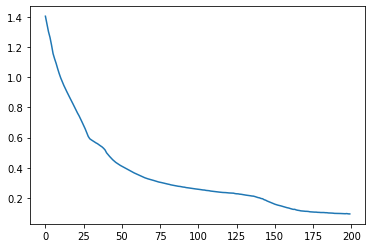

In [9]:
plt.plot(myloss);
best = np.argmin(myloss)
bestparameter = myparameter[best]
for l in range(len(bestparameter)):
    MyAgedPNN[l].theta_.data = bestparameter[l]

In [10]:
import evaluation
import importlib
from tqdm.notebook import tqdm
importlib.reload(evaluation)

test_time = np.linspace(0,1,100)
my_aged_acc = []
my_acc = []
my_aged_maa = []
my_maa = []

for test_t in test_time:
    for i in MyAgedPNN:
        i.t = test_t
    for i in MyPNN:
        i.t = test_t
    
    my_aged_acc.append(evaluation.BASIC(MyAgedPNN, x_test, y_test))
    my_acc.append(evaluation.BASIC(MyPNN, x_test, y_test))
    
    my_aged_maa.append(evaluation.MAA(MyAgedPNN, x_test, y_test))
    my_maa.append(evaluation.MAA(MyPNN, x_test, y_test))

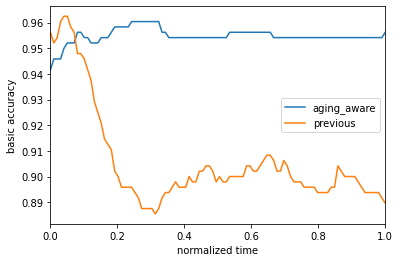

In [11]:
plt.plot(test_time, my_aged_acc, label='aging_aware');
plt.plot(test_time, my_acc, label='previous');
plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

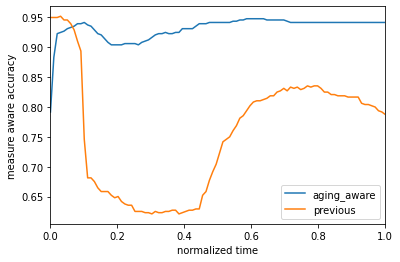

In [12]:
plt.plot(test_time, my_aged_maa, label='aging_aware');
plt.plot(test_time, my_maa, label='previous');
plt.xlabel('normalized time');
plt.ylabel('measure aware accuracy');
plt.xlim([0, 1])
plt.legend();